In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import anndata as ad

In [2]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False,
                              figsize = [5,5])
cr.settings.verbosity = 2
rc2_loom_path = '/project/gca/yuzhao1/work/final_RC2rna/upstream/'
gca_loom_path = '/project/gca/yuzhao1/work/final_GCArna/upstream/'
input_path = '/project/gca/yuzhao1/work/final_RC2rna/velocity/epithelial/'
SampleIDs = pd.read_csv("/project/gca/yuzhao1/work/final_RC2rna/metadata/SampleIDs.csv")['SampleID']

In [ ]:
######################## part 1: process ##########################

In [ ]:
# loomdata = []
# for i in SampleIDs:
#     if('PP' in i or 'POU' in i):
#         temp = scv.read(rc2_loom_path + i + '/velocyto/' + i + '.loom', cache=True)
#     if('TI' in i or 'AC' in i):
#         temp = scv.read(gca_loom_path + i + '/velocyto/' + i + '.loom', cache=True)
#     barcodes = [bc.replace(':','_').replace('x','-1') for bc in temp.obs.index.tolist()]
#     temp.obs.index = barcodes
#     temp.var_names_make_unique()
#     loomdata.append(temp)

In [ ]:
# # concatenate the looms
# loomdata_union = ad.concat(loomdata)

In [ ]:
# # save
# import pickle
# filename = input_path+'loomdata_union.pkl'
# pickle.dump(loomdata_union, 
#             open(filename, 'wb'))

In [ ]:
import pickle
filename = input_path+'loomdata_union.pkl'
loomdata_union = pickle.load(open(filename, 'rb'))

In [ ]:
# merge matrices into the original adata object
adata = sc.read_h5ad(input_path+'adata_input.h5ad')
# add metadata and visualize
cell_meta = pd.read_csv(input_path+"metadata.csv")
adata.obs['anno1'] = cell_meta['anno1'].values

In [ ]:
adata = scv.utils.merge(adata, loomdata_union)

In [ ]:
# # additional process steps
# # normalize X, spliced and unspliced
# # pre-process, pre-filter all tiny noises
# scv.pp.filter_genes(adata, min_shared_counts=10)
# scv.pp.normalize_per_cell(adata, enforce=True) 
# scv.pp.log1p(adata)

# # get highly variable genes
# scv.pp.filter_genes_dispersion(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# sc.pp.regress_out(adata, ['nCount_RNA', 'percent.mt', 'CC.Difference'])
# sc.pp.scale(adata, max_value=10)

In [ ]:
adata

In [ ]:
# plot umap to check
sc.pl.umap(adata, color='anno1', frameon=False, legend_loc='on data', title='', save='_all_umap.png')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['anno1'], legend_loc='on data', title='', frameon=False, save=None)
# sc.pl.umap(adata, color=['anno1'], title='', frameon=False, save=None)

In [ ]:
adata.obsm['X_harmony_umap2'] = adata.obsm['X_umap']

In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=200, n_top_genes=2000)

In [ ]:
sum(adata.var.highly_variable)

In [ ]:
tempann = adata.copy()
sc.pp.regress_out(tempann, ['nCount_RNA', 'percent.mt', 'CC.Difference'])
sc.pp.scale(tempann, max_value=10)
sc.tl.pca(tempann, svd_solver='arpack', n_comps=50)
import scanpy.external as sce
sce.pp.harmony_integrate(tempann, 'Patient_ID', max_iter_harmony = 20)
adata.obsm['X_pca'] = tempann.obsm['X_pca_harmony']
adata.obsm['X_pca']

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)

In [ ]:
scv.pp.moments(adata, use_rep='X_pca', n_pcs=50, 
               n_neighbors=30, use_highly_variable=True)

In [ ]:
scv.pl.proportions(adata, groupby='anno1', save=None)

In [ ]:
adata

In [ ]:
# save dataset as anndata format
adata.write(input_path+'adata_preprocessed_ReadyToSubset.h5ad')

In [ ]:
# read the processed data from above
adata = sc.read_h5ad(input_path+'adata_preprocessed_ReadyToSubset_stochatic.h5ad')

In [ ]:
######################## A: subset to pouch ##########################

In [ ]:
# notes: finalized pouch parameters: using 50pc (obtained from union PCs), 30neighbors(recomputed), as following

In [ ]:
adata = adata[adata.obs['biopsy_location'].isin(['POU'])]

In [ ]:
sc.pl.umap(adata, color=['anno1'], legend_loc='on data', title='', 
           frameon=False, save='pouch_umap_withname.png')

In [ ]:
adata

In [ ]:
scv.pp.filter_and_normalize(adata, min_shared_counts=25, n_top_genes=2000)

In [ ]:
adata

In [ ]:
# use union pca, no need to recompute
# tempann = adata.copy()
# sc.pp.regress_out(tempann, ['nCount_RNA', 'percent.mt', 'CC.Difference'])
# sc.pp.scale(tempann, max_value=10)
# sc.tl.pca(tempann, svd_solver='arpack', n_comps=50)
# import scanpy.external as sce
# sce.pp.harmony_integrate(tempann, 'Patient_ID', max_iter_harmony = 20)
# adata.obsm['X_pca'] = tempann.obsm['X_pca_harmony']
# adata.obsm['X_pca']

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', n_pcs=50)


In [ ]:
scv.pp.moments(adata, use_rep='X_pca', n_pcs=50, 
               n_neighbors=30, use_highly_variable=True)

In [ ]:
######################## part 2.1: Run dynamical model ##########################

In [ ]:
# dynamics model requires to run scv.tl.recover_dynamics(adata, **params) beforehand
scv.tl.recover_dynamics(adata, n_jobs=4)

# compute velocity
scv.tl.velocity(adata, mode='dynamical', diff_kinetics=True)

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

scv.tl.velocity_graph(adata, n_neighbors=30, n_jobs=4)

scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False,
                              figsize = [5,5])

In [ ]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='anno1', 
                               save=False, title='', scale=0.2)

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['anno1'],  
                                 density=2, cutoff_perc=0, min_mass=3,size=50,
                                 smooth =None, integration_direction = 'both',
                                 save='pouch_withname.png', title='',
                                 groups=['Stem', 'TA', 'EC1-1', 'EC1-2', 'EC1-3', 'EC1-MMP1', 'M-like',
                                          'EC2-1', 'EC2-2','EC2-3'],
                                legend_loc='on data')
# scv.pl.velocity_embedding_stream(adata, basis='harmony_umap', color=['anno1'],  
#                                  density=1, cutoff_perc=5, min_mass=1,size=50,
#                                  smooth =None, integration_direction = 'both',
#                                  save=None, title='',
#                                  groups=['Stem', 'TA', 'EC1-1', 'EC2-1','EC2-3'])

In [ ]:
# save dataset as anndata format
adata.write(input_path+'pouch/adata_dynamical_output.h5ad')
# adata.write(input_path+'pouch/adata_pouch_dynamical_output.h5ad')

In [ ]:
adata

In [ ]:
######################## part 2.2: Run stochastic model with differential kinetics ###############

In [ ]:
scv.tl.velocity(adata, diff_kinetics=True, mode='stochastic')

!jupyter nbextension enable --py widgetsnbextension

scv.tl.velocity_graph(adata, n_neighbors=30, n_jobs=4)

scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False,
                              figsize = [5,5])

In [ ]:
scv.pl.velocity_embedding_grid(adata, basis='X_harmony_umap', color='anno1', 
                               save=False, title='', scale=0.2)

In [ ]:
# scv.pl.velocity_embedding_stream(adata, basis='X_harmony_umap2', color=['anno1'],  
#                                  density=2, cutoff_perc=5, min_mass=0,size=20,
#                                  smooth =None, integration_direction = 'both',
#                                  save='pouch_stochastic.png', title='',
#                                  groups=['Stem', 'TA', 'EC1-1', 'EC1-2', 'EC1-3', 'EC1-MMP1', 'M-like',
#                                           'EC2-1', 'EC2-2','EC2-3'])
scv.pl.velocity_embedding_stream(adata, basis='X_harmony_umap2', color=['anno1'],  
                                 density=2, cutoff_perc=5, min_mass=3,size=20,
                                 smooth =None, integration_direction = 'both',
                                 save=False, title='')

In [ ]:
# # save dataset as anndata format
# adata.write(input_path+'pouch/adata_stochastic_output.h5ad')

In [ ]:
# save dataset as anndata format
# adata.write(input_path+'adata_stochastic_output.h5ad')

In [ ]:
######################## part 3: visualize ##########################

In [3]:
# reload dataset
adata = sc.read_h5ad(input_path+'adata_dynamical_output.h5ad')

In [4]:
adata.obs.loc[adata.obs['anno1'] == 'EC1-MMP1', 'anno1'] = 'EC1-3'

In [ ]:
pd.DataFrame(adata.obsm['X_umap']).to_csv('umap.csv', header=False, index = False)

In [ ]:
sc.pl.umap(adata, color=['anno1'], legend_loc='on data', title='', 
           frameon=False, save=None)

In [ ]:
# # load new umap from cell metadata:
# cell_meta = pd.read_csv(input_path+"metadata.csv")
# adata.obsm['X_umap'] = np.vstack((cell_meta['embedding1'].to_numpy(), cell_meta['embedding2'].to_numpy())).T

In [5]:
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=300, frameon=False,
                              figsize = [5,5])

saving figure to file ./figures/scvelo_pouch directions.png


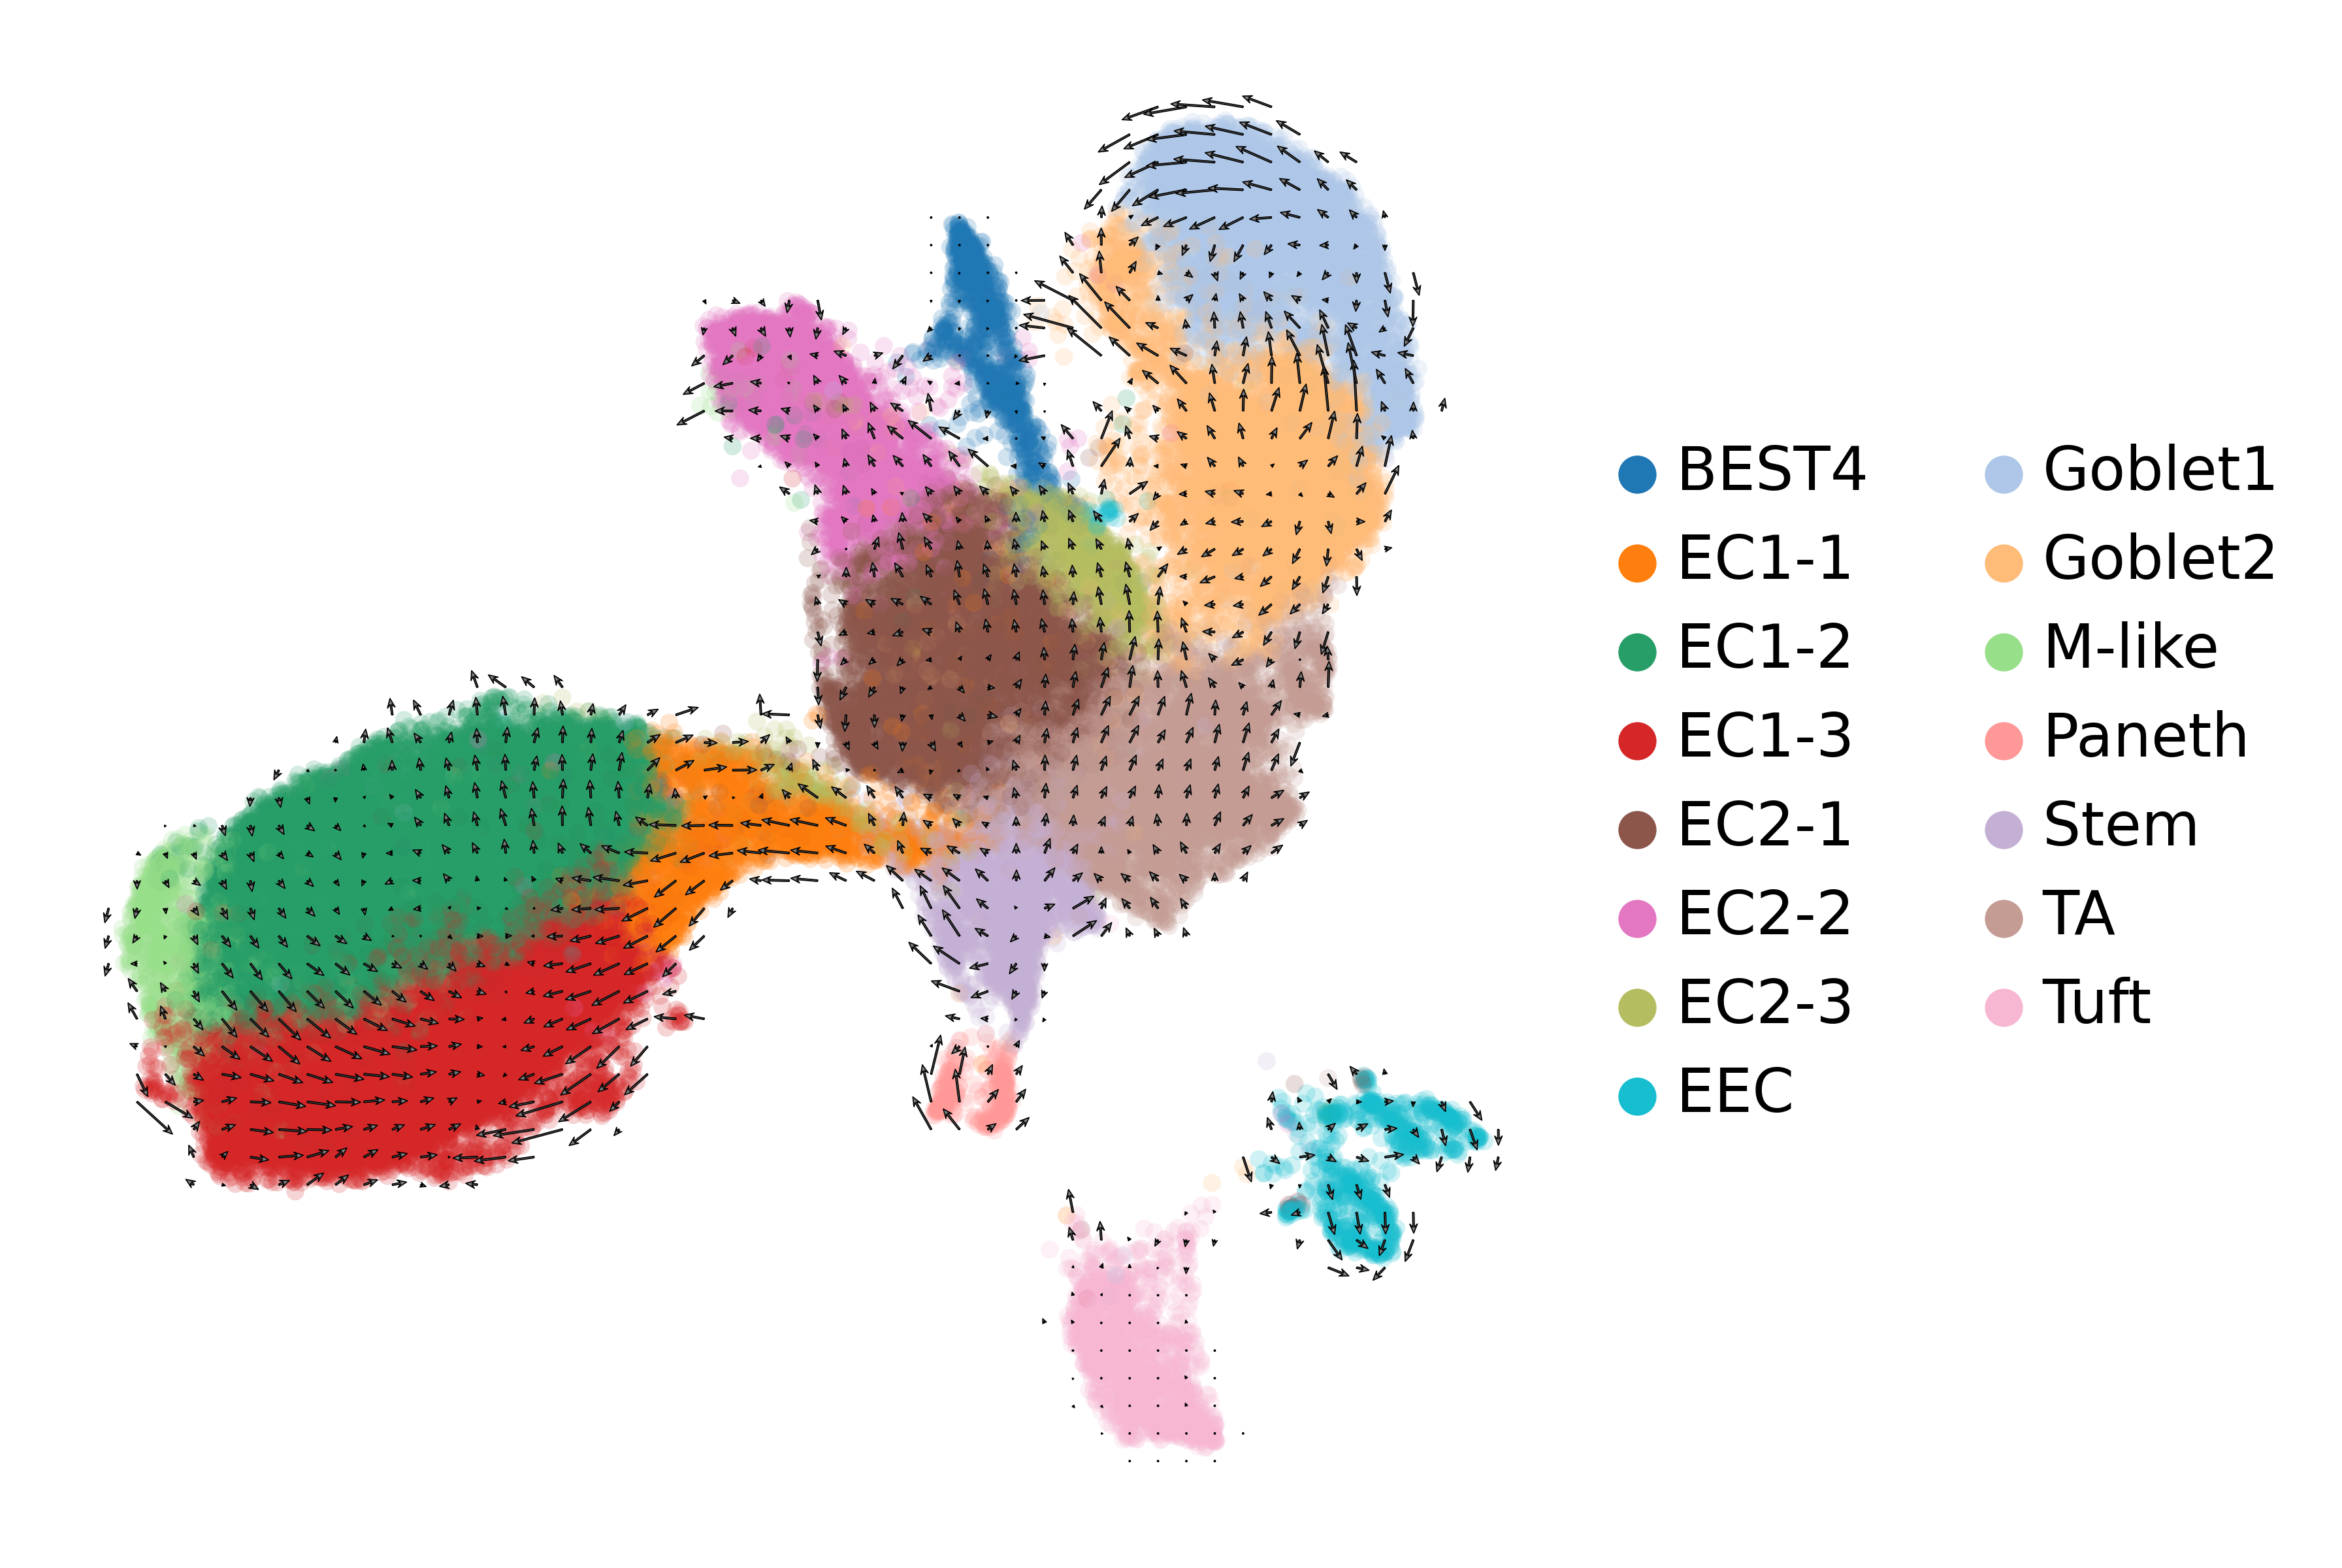

In [6]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='anno1', legend_loc='right margin',
                               save='pouch directions.png', title='', scale=0.5)

saving figure to file ./figures/scvelo_pouch stream.png


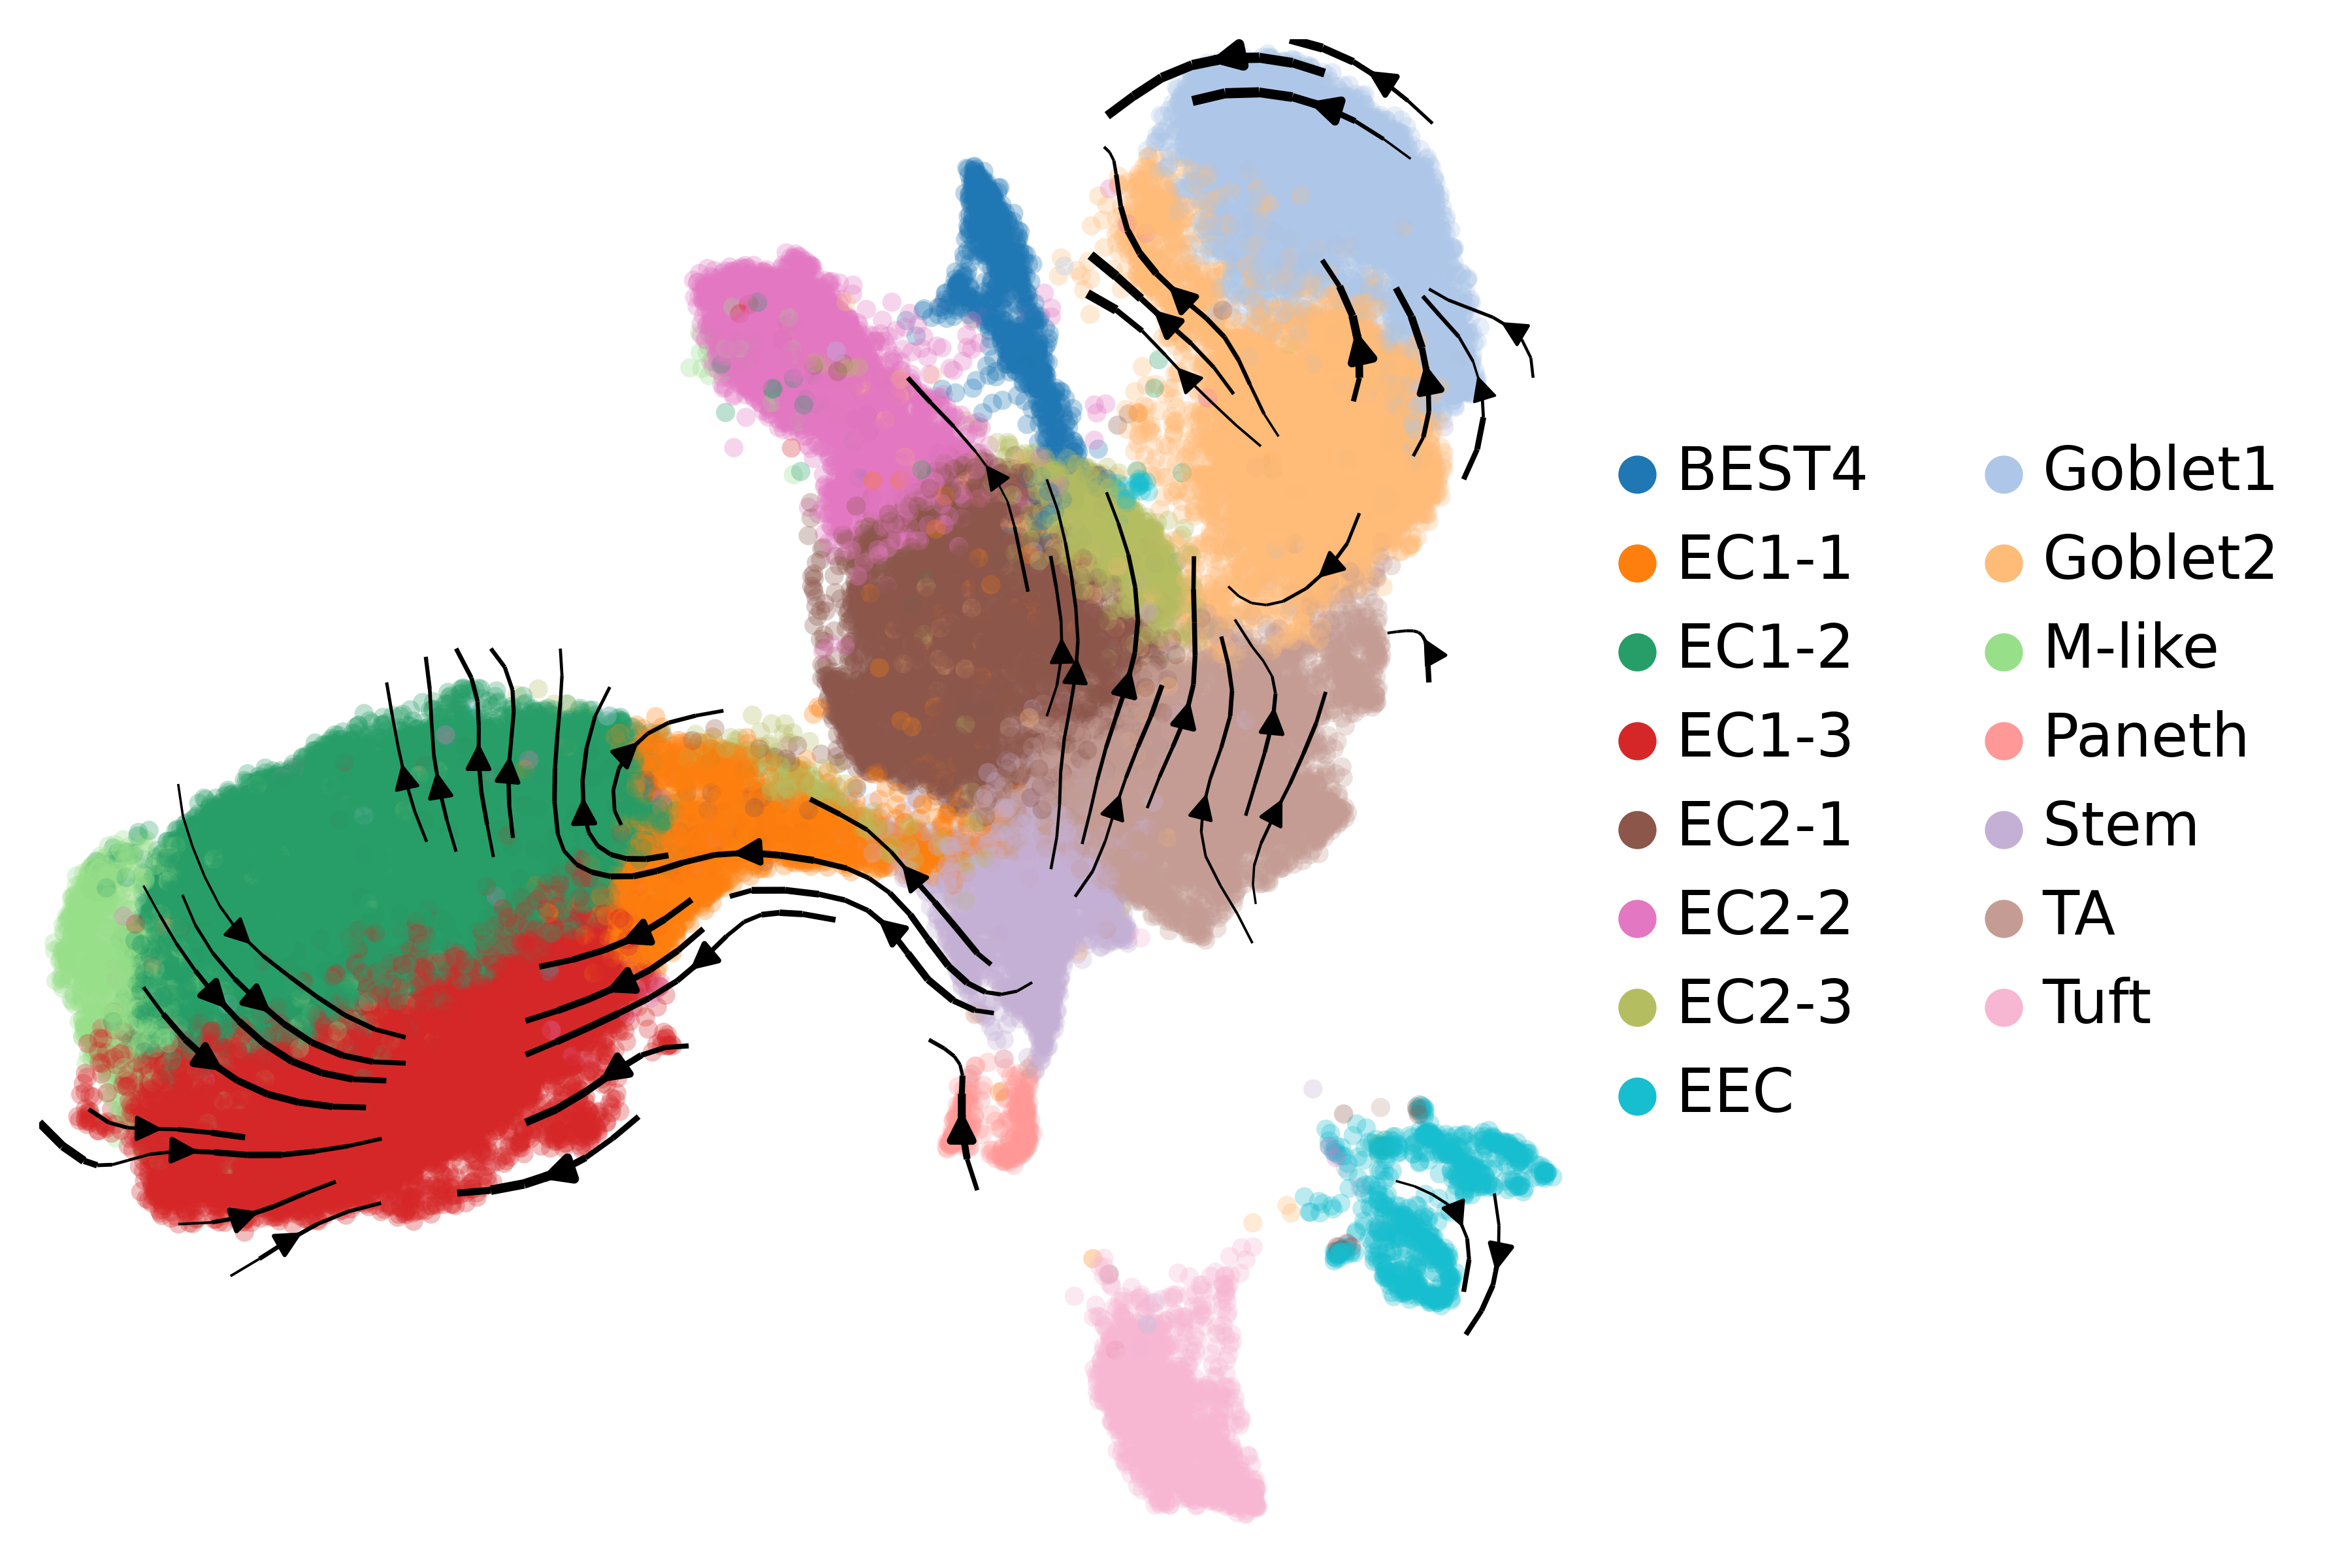

In [7]:
# # pouch
# scv.pl.velocity_embedding_stream(adata, basis='umap', color=['anno1'],  
#                                  density=1.5, cutoff_perc=1, min_mass=3.5, size=50,
#                                  integration_direction = 'both',
#                                  save= False, title='', smooth=0.8,
#                                  groups=['Stem', 'TA', 'EC1-1', 'EC1-2', 'EC1-3', 'M-like',
#                                           'EC2-1', 'EC2-2','EC2-3'],
#                                 legend_loc='right margin')
# pouch
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['anno1'],  
                                 density=1.5, cutoff_perc=1, min_mass=3.5, size=50,
                                 integration_direction = 'both',
                                 save= 'pouch stream.png', title='', smooth=0.8,
                                 legend_loc='right margin')
# union
# scv.pl.velocity_embedding_stream(adata, basis='umap', color=['anno1'],  
#                                  density=1.5, cutoff_perc=1, min_mass=3.3, size=30,
#                                  integration_direction = 'both',
#                                  save= 'union.png', title='', smooth=0.8,
#                                  groups=['Stem', 'TA', 'EC1-1', 'EC1-2', 'EC1-3', 'M-like',
#                                           'EC2-1', 'EC2-2','EC2-3'],
#                                 legend_loc='right margin')
# scv.pl.velocity_embedding_stream(adata, basis='umap', color=['anno1'],  
#                                  density=1.5, cutoff_perc=1, min_mass=3.3, size=30,
#                                  integration_direction = 'both',
#                                  save= 'union stream.png', title='', smooth=0.8,
#                                  legend_loc='right margin')

In [ ]:
sc.tl.louvain(adata, resolution=0.5)

In [ ]:
sc.pl.umap(adata, color=['louvain'], legend_loc='on data')

In [ ]:
############### part 4: downstream analysis ###############

In [9]:
x = adata.var.index[np.where(adata.var['velocity_genes'] )]
np.savetxt("epithelial/velocity_genes.csv", x, delimiter=",", fmt='%s')

In [ ]:
# waiting for libtbb
import cellrank
cellrank.tl.terminal_states(adata) # this is an improved version of scVelo

In [ ]:
scv.tl.velocity_clusters(adata)
scv.pl.scatter(adata, color='velocity_clusters')

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby='anno1', min_corr=.3)

In [ ]:
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head(20)

In [ ]:
adata

In [ ]:
scv.pl.velocity(adata, ["SATB2","TFCP2L1","PPARG","ZBTB10"], color='anno1', basis = 'X_harmony_umap2',
                ncols=1, save = '_markers_all.pdf', dpi=300)

In [ ]:
scv.pl.scatter(adata, 'LGR5', color=['anno1', 'velocity'])

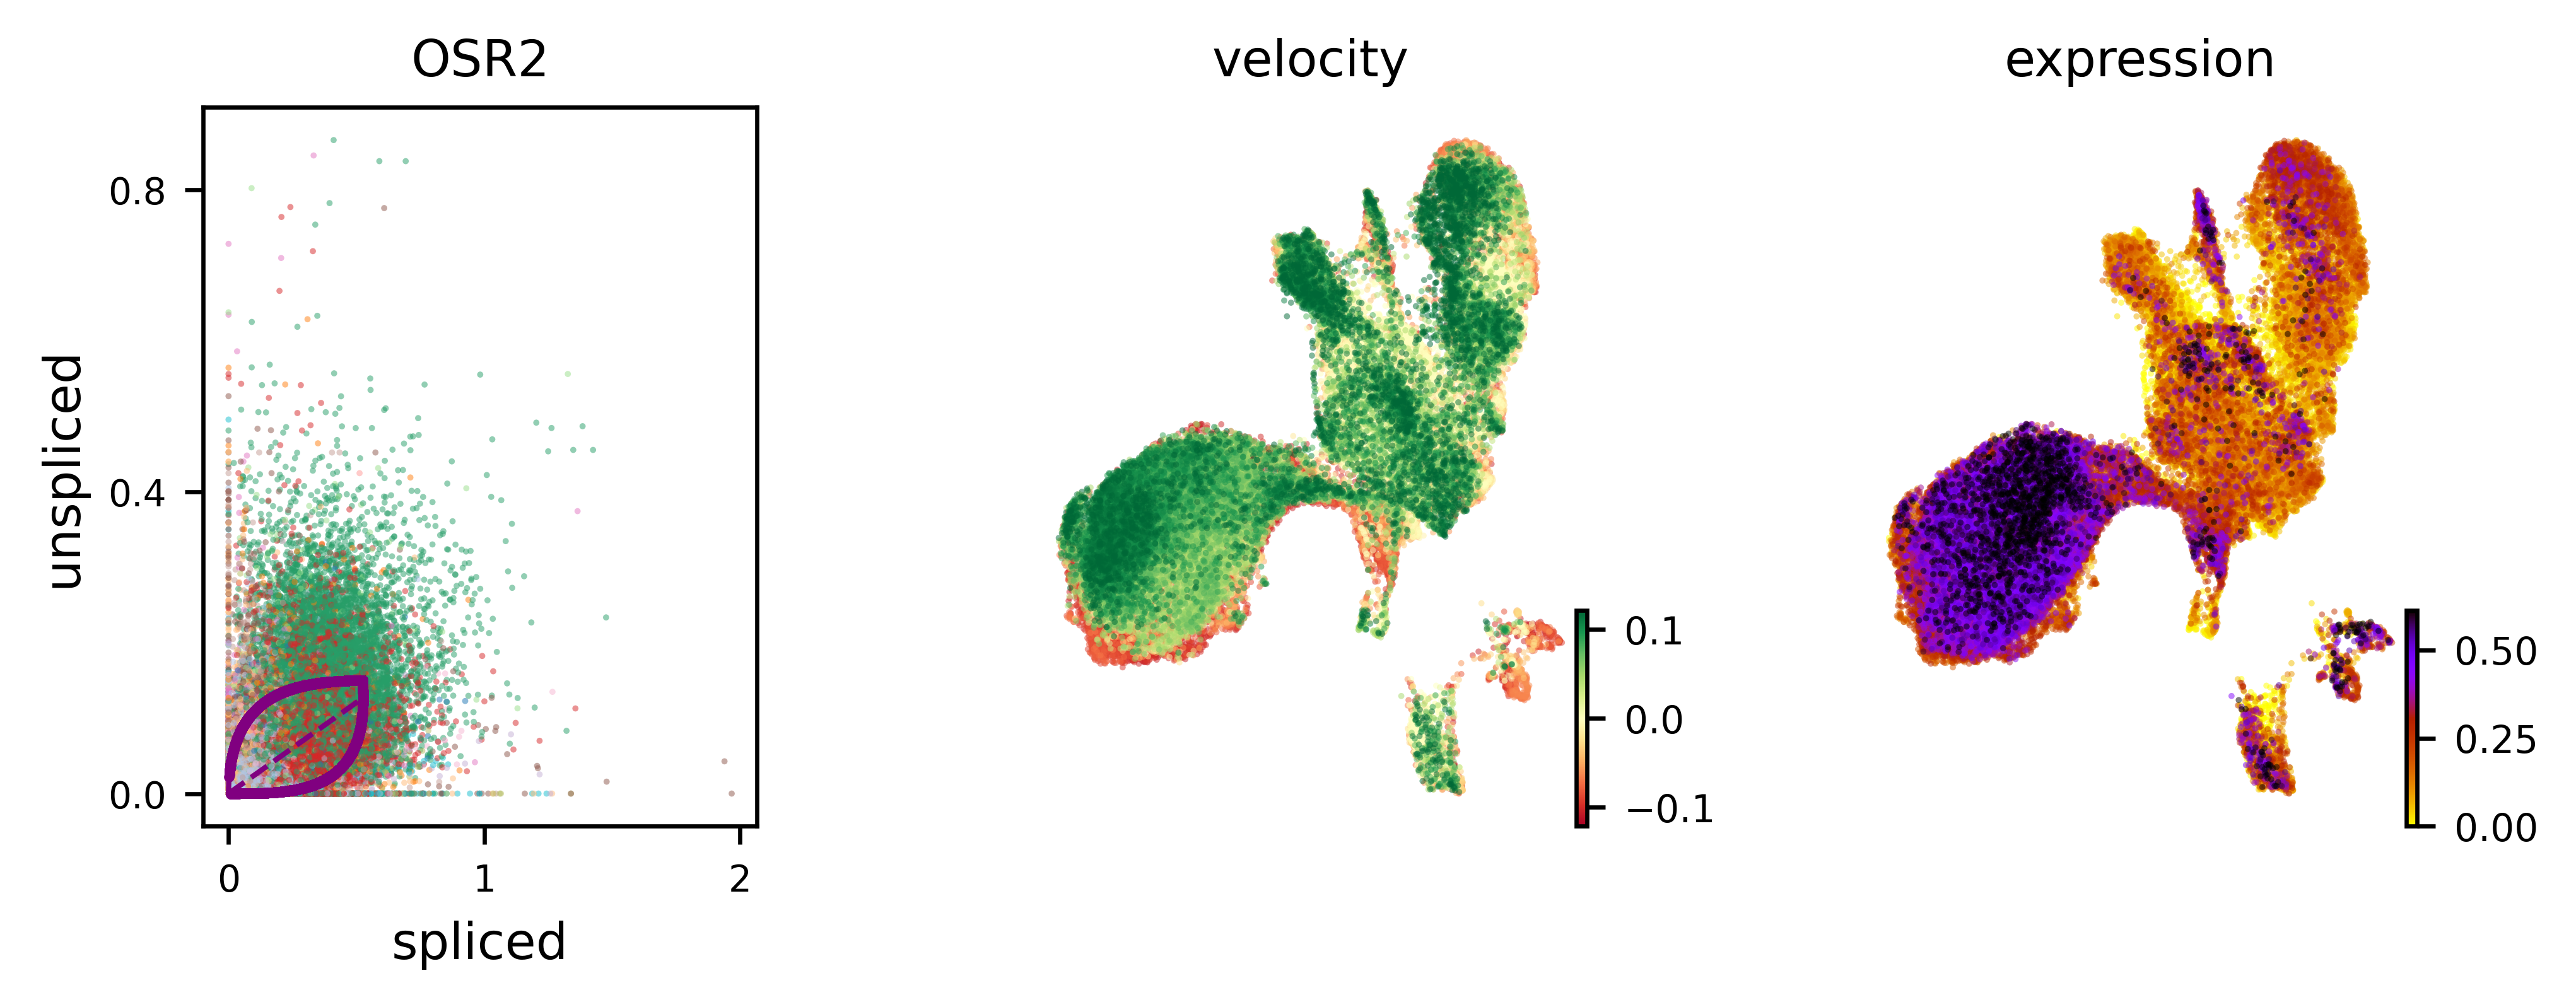

In [14]:
scv.pl.velocity(adata, ['OSR2'], ncols=1, color='anno1')

In [ ]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby='anno1', min_corr=.3)

In [ ]:
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head(20)

In [ ]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index)

In [ ]:
scv.pl.scatter(adata, color='anno1', basis=top_genes[:15], ncols=5, frameon=False)

In [ ]:
top_genes

In [ ]:
############### part 5: cellrank ###############
# not suitable for our dataset, they lack a general adaptability

In [ ]:
adata = sc.read_h5ad(input_path+'adata_stochastic_output.h5ad')

In [ ]:
import cellrank as cr
import tbb

In [ ]:
cr.tl.terminal_states(adata, cluster_key="anno1", weight_connectivities=0.2)

In [ ]:
cr.pl.terminal_states(adata)

In [ ]:
cr.tl.initial_states(adata, cluster_key="anno1")
cr.pl.initial_states(adata, discrete=True)

In [ ]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False)

In [ ]:
cr.pl.lineages(adata, same_plot=True)


In [ ]:
scv.tl.recover_latent_time(
    adata, root_key="initial_states_probs", end_key="terminal_states_probs"
)